In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'

import seaborn as sns

import sys,os,pdb,copy,pickle
from importlib import reload
import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
sys.path.append('/mnt/home/szheng/projects/place_variability/code')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp
import database
db = database.db

import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)

import process_central_arm as pca 
import change_point_analysis_central_arm_seperate as cpacas

import misc
reload(misc)
from misc import get_nth_key, get_nth_val

67 sessions!
67 sessions!


/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [7]:

n_inputs = 10
n_trials = 20
inputs = np.random.normal(1,10,size=(n_inputs,n_trials))
n_hidden = 100
w_hi_init = np.exp(np.random.normal(0,1,size=(n_hidden,n_inputs)))
n_out = 100
w_oh_init = np.exp(np.random.normal(0,1,size=(n_out,n_hidden)))

In [ ]:
# class Experiment():
#     def __init__(self):
        

(array([62., 19.,  9.,  2.,  3.,  2.,  2.,  0.,  0.,  1.]),
 array([ 0.05471769,  1.42172567,  2.78873365,  4.15574164,  5.52274962,
         6.8897576 ,  8.25676559,  9.62377357, 10.99078155, 12.35778953,
        13.72479752]),
 <BarContainer object of 10 artists>)

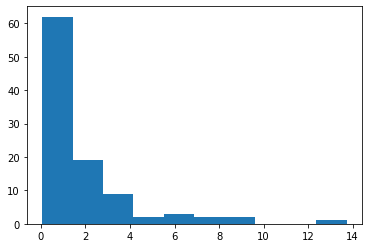

In [141]:
# cc=np.random.beta(1,20,size=100)
cc=np.exp(np.random.normal(0,1,size=100))
plt.hist(cc)

In [86]:
np.random.rand(10,20)

array([[0.67272339, 0.24833927, 0.315329  , 0.03728097, 0.27587424,
        0.94260147, 0.78569306, 0.9430245 , 0.97011832, 0.82450651,
        0.80050083, 0.61819028, 0.77229712, 0.16250361, 0.6246998 ,
        0.03477647, 0.67230868, 0.68079876, 0.85200359, 0.12289998],
       [0.56256107, 0.44432436, 0.01083364, 0.74684289, 0.93826085,
        0.74726086, 0.4614208 , 0.05177884, 0.2335377 , 0.12546675,
        0.10648053, 0.6217209 , 0.21261049, 0.07901787, 0.03552691,
        0.37333746, 0.40491961, 0.50294449, 0.58562246, 0.28642406],
       [0.87158351, 0.17442795, 0.38533754, 0.78333767, 0.16790538,
        0.29623676, 0.88817837, 0.0256185 , 0.71166697, 0.90559339,
        0.22967121, 0.16850224, 0.84317055, 0.43330365, 0.12682262,
        0.71566083, 0.6259964 , 0.6669627 , 0.12704742, 0.35430255],
       [0.39688215, 0.59913098, 0.77267243, 0.43057363, 0.98153857,
        0.52207763, 0.83621126, 0.31502151, 0.71381884, 0.50369077,
        0.79600234, 0.40771793, 0.39931923, 0

In [646]:
def init_c(n_pre,n_post,a=1,b=20):
    frac_c = np.random.beta(a,b,size=n_post)
    C = np.random.rand(n_post,n_pre) < frac_c[:,None]
    return C

def init_w(n_pre,n_post,a=1,b=20,mu=0,sigma=1):
#     w =np.abs(np.random.normal(mu,sigma,size=(n_post,n_pre))) 
    w = 1
    c = init_c(n_pre,n_post,a=a,b=b)
    w = w*c / n_pre
    return w,c
    

0.999999694097773

In [719]:
def generate_hidden(**kwargs):
    n_trials = kwargs.get('n_trials',20)
    n_hidden = kwargs.get('n_hidden',100)
    n_in_ensemble = kwargs.get('n_in_ensemble',20)
    n_ensembles = int(np.floor(n_hidden / n_in_ensemble))
    factor_l = []
    for n in range(n_ensembles):    
        factor = np.zeros(n_hidden)
        factor[n*n_in_ensemble : (n+1)*n_in_ensemble] = np.random.normal(1,0.001,size=n_in_ensemble)
        factor_l.append(factor)
    factor_l = np.stack(factor_l,axis=1)
    cov = factor_l.dot(factor_l.T)
    mean = np.ones(n_hidden) * 0
    hidden_baseline = np.exp(np.random.normal(0,1,size=(n_hidden)))
    correlated_noise =np.random.multivariate_normal(mean,cov,size=(n_trials)).T
    hidden_l = hidden_baseline[:,None] + correlated_noise
    hidden_l[hidden_l<0] = 0
    return hidden_l

def update_w(w,p=0.01,clip_range=[0,10],dw=1.):
    w = copy.copy(w)
    plus_mask_p = np.mean(w!=0)
    update_mask = np.random.rand(*w.shape) < p
    plus_mask = np.random.rand(*w.shape) < plus_mask_p
    update_plus_mask = update_mask & plus_mask
    update_minus_mask = update_mask & np.logical_not(plus_mask)
    w[update_plus_mask] = w[update_plus_mask] + dw
    w[update_minus_mask] = w[update_minus_mask] - dw

    w[w<clip_range[0]] = clip_range[0]
    w[w>clip_range[1]] = clip_range[1]

    return w

def update_c(c,p_on=0.01,p_off=0.05,b=0.05,s=0.05):
    c = copy.copy(c)
    frac_0 = (c == 0).mean(axis=1)
    frac_1 = (c == 1).mean(axis=1)   
    p_turn1 = scipy.special.expit((frac_0-b)/s) * p_on
    
    p_turn0 = scipy.special.expit((frac_1-b)/s) * p_off
    
    flip1 = np.random.rand(*c.shape) < p_turn1[:,None] 
    flip0 = np.random.rand(*c.shape) < p_turn0[:,None] 
    
    c[flip1] = 1
    c[flip0] = 0
    return c
    
def simulate(**kwargs):
    # n_inputs = kwargs.get('n_inputs',10)
    n_hidden = kwargs.get('n_hidden',100)
    n_out = kwargs.get('n_out',100)
    n_trials = kwargs.get('n_trials',20)
    p = kwargs.get('p',0.01)
    p_on = kwargs.get('p_on',0.01)
    p_off = kwargs.get('p_off',0.05)
    clip_range = kwargs.get('clip_range',[0,10])
    dw = kwargs.get('dw',1.)
    dw = dw / np.sqrt(n_hidden)
    a = kwargs.get('a',1.)
    b = kwargs.get('b',20.)
    mu = kwargs.get('mu',1)
    sigma = kwargs.get('sigma',1)
    # input_mu = kwargs.get('input_mu',1)
    # input_sigma = kwargs.get('input_sigma',1)
    hidden_l = generate_hidden(**kwargs)
    w_oh_init,c_oh_init = init_w(n_hidden,n_out,a=a,b=b,mu=mu,sigma=sigma)
    w_oh_l = [w_oh_init]
    c_oh_l = [c_oh_init]
    out_l = []

    for t in range(n_trials):
    #     input_t = inputs[:,t]
        hidden_t = hidden_l[:,t]
#         w_hi = w_hi_init
        w_oh = w_oh_l[t]
        c_oh = c_oh_l[t]
        out = w_oh.dot(hidden_t)
        out_l.append(out)
#         w_oh_new = update_w(w_oh,p=p,clip_range=clip_range,dw=dw)
#         c_oh_new = update_c(c_oh,p=p)
        c_oh_new = update_c(c_oh,p_on=p_on,p_off=p_off)
        w_oh_new = c_oh_new * 1 / n_hidden
        w_oh_l.append(w_oh_new)
        c_oh_l.append(c_oh_new)

    w_oh_l = np.stack(w_oh_l,axis=-1)
    out_l = np.stack(out_l,axis=-1)
    c_oh_l = np.stack(c_oh_l,axis=-1)
    return w_oh_l,c_oh_l, out_l, hidden_l

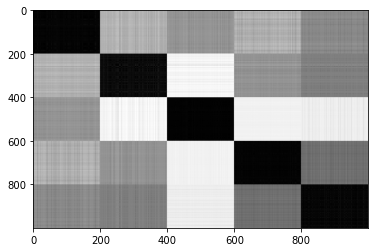

In [720]:
plt.imshow(np.corrcoef(hidden_l),aspect='auto')

In [724]:
w_oh_l,c_oh_l,out_l,hidden_l = simulate(n_hidden=1000,n_in_ensemble=200,n_out=500,sigma=0.0001,dw=0.01,p_on=0.01,p_off=0.3,clip_range=[0,0.02])


In [725]:
fr_rank = np.argsort(out_l.sum(axis=1))
out_l_sorted = out_l[fr_rank]

In [726]:
c_oh_l.sum(axis=(0,1))

array([24355, 23720, 23599, 23761, 24161, 24590, 24877, 25223, 25402,
       25466, 25705, 25884, 25921, 26016, 26055, 26262, 26275, 26080,
       26073, 26085, 26069])

In [718]:
aa=c_oh_l[:,:,0]
print(aa.sum())
aa_next=update_c(aa,p_off=0.3)
print(aa_next.sum())

22348
22200


(array([476239.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  23761.]),
 array([0.    , 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007,
        0.0008, 0.0009, 0.001 ]),
 <BarContainer object of 10 artists>)

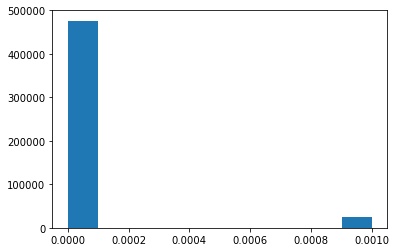

In [727]:
plt.hist(w_oh_l[:,:,3].ravel())

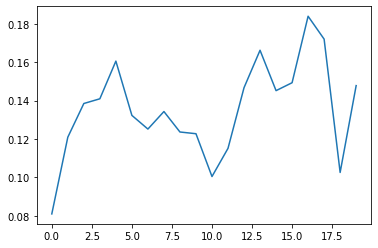

In [741]:
plt.plot(out_l_sorted[490])

In [529]:
out_l

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.07274072],
       [ 0.00222696,  0.00829627,  0.00865507, ...,  0.00422716,
        -0.15772963,  0.06551196],
       [ 0.01049908,  0.0329475 ,  0.03842871, ...,  0.02382958,
         0.03294289,  0.01963149],
       ...,
       [ 0.09065641,  0.22964228,  0.25782733, ...,  0.07704478,
        -0.07625321,  0.1796023 ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.11129592,  0.13605103],
       [ 0.0842457 ,  0.03905432,  0.01045188, ...,  0.47333777,
         0.31750528,  0.19865222]])

In [419]:
def forward_pass(input_t,w_hi,w_oh):
    hidden = w_hi.dot(input_t)
    out = w_oh.dot()
    return out

def update_w(w,p=0.01,clip_range=[0,10],dw=1.):
    w = copy.copy(w)
    plus_mask_p = np.mean(w!=0)
    update_mask = np.random.rand(*w.shape) < p
    plus_mask = np.random.rand(*w.shape) < plus_mask_p
    update_plus_mask = update_mask & plus_mask
    update_minus_mask = update_mask & np.logical_not(plus_mask)
    w[update_plus_mask] = w[update_plus_mask] + dw
    w[update_minus_mask] = w[update_minus_mask] - dw

    w[w<clip_range[0]] = clip_range[0]
    w[w>clip_range[1]] = clip_range[1]
    
    return w
    
def simulate(**kwargs):
    n_inputs = kwargs.get('n_inputs',10)
    n_hidden = kwargs.get('n_hidden',100)
    n_out = kwargs.get('n_out',100)
    n_trials = kwargs.get('n_trials',20)
    p = kwargs.get('p',0.01)
    clip_range = kwargs.get('clip_range',[0,10])
    dw = kwargs.get('dw',1.)
    dw = dw / np.sqrt(n_hidden)
    a = kwargs.get('a',1.)
    b = kwargs.get('b',20.)
    mu = kwargs.get('mu',1)
    sigma = kwargs.get('sigma',1)
    input_mu = kwargs.get('input_mu',1)
    input_sigma = kwargs.get('input_sigma',1)
    
    
    inputs = np.abs(np.random.normal(input_mu,input_sigma,size=(n_inputs,n_trials)))
#     w_hi_init = np.exp(np.random.normal(0,1,size=(n_hidden,n_inputs)))  /n_inputs
#     w_oh_init = np.exp(np.random.normal(0,1,size=(n_out,n_hidden))) /n_hidden
    w_hi_init,c_hi = init_w(n_inputs,n_hidden,a=a,b=b,mu=mu,sigma=sigma)
    w_oh_init,c_oh = init_w(n_hidden,n_out,a=a,b=b,mu=mu,sigma=sigma)
    
    w_oh_l = [w_oh_init]
#     hidden_l = []
    out_l = []
    
    for t in range(n_trials):
        input_t = inputs[:,t]
        w_hi = w_hi_init
        w_oh = w_oh_l[t]
        out = forward_pass(input_t,w_hi,w_oh)
        out_l.append(out)
        w_oh_new = update_w(w_oh,p=p,clip_range=clip_range,dw=dw)
        w_oh_l.append(w_oh_new)

    
    w_oh_l = np.stack(w_oh_l,axis=-1)
    out_l = np.stack(out_l,axis=-1)
    return out_l, w_oh_l,inputs,w_hi_init,c_hi,c_oh
        
        
    

In [420]:
out_l,w_oh_l,inputs,w_hi_init,c_hi,c_oh = simulate(n_hidden=1000,n_out=200,sigma=0.0001,
                                                             dw=0.01,p=0.01,clip_range=[0,0.02],
                                                   input_sigma=0.1
                                                            )

(array([3.70000e+01, 0.00000e+00, 1.89900e+04, 0.00000e+00, 1.27760e+04,
        2.96100e+03, 0.00000e+00, 1.77696e+05, 0.00000e+00, 8.47000e+02]),
 array([5.12236367e-05, 1.77750822e-04, 3.04278006e-04, 4.30805191e-04,
        5.57332376e-04, 6.83859561e-04, 8.10386746e-04, 9.36913931e-04,
        1.06344112e-03, 1.18996830e-03, 1.31649549e-03]),
 <BarContainer object of 10 artists>)

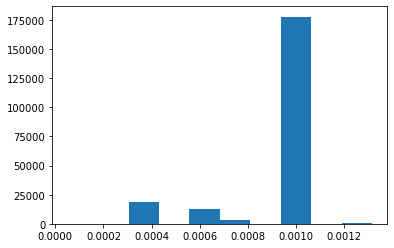

In [421]:
plt.hist(w_oh_l[w_oh_l!=0])

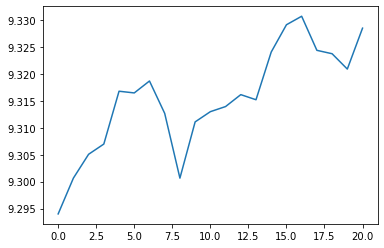

In [422]:
plt.plot(w_oh_l.sum(axis=(0,1)))

(array([71., 44., 38., 24.,  9.,  5.,  4.,  2.,  0.,  3.]),
 array([0.        , 0.00116264, 0.00232528, 0.00348792, 0.00465056,
        0.0058132 , 0.00697584, 0.00813848, 0.00930112, 0.01046376,
        0.0116264 ]),
 <BarContainer object of 10 artists>)

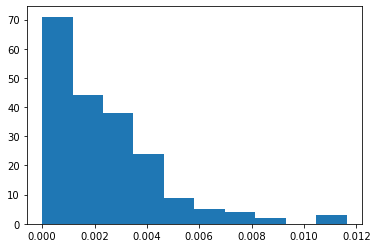

In [423]:
plt.hist(out_l[:,19])

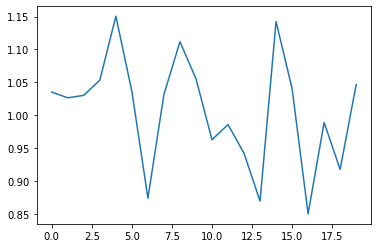

In [424]:
plt.plot(inputs[1])

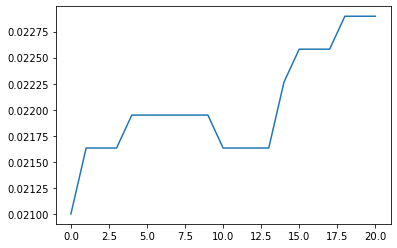

In [432]:
u = 28
plt.plot(np.sum(w_oh_l[u],axis=0))

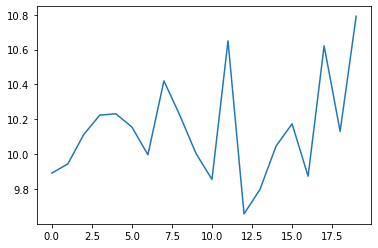

In [433]:
plt.plot(np.sum(inputs,axis=0))

(array([40., 47., 45., 24., 19., 11.,  7.,  4.,  2.,  1.]),
 array([0.00500707, 0.05757547, 0.11014386, 0.16271226, 0.21528066,
        0.26784905, 0.32041745, 0.37298584, 0.42555424, 0.47812264,
        0.53069103]),
 <BarContainer object of 10 artists>)

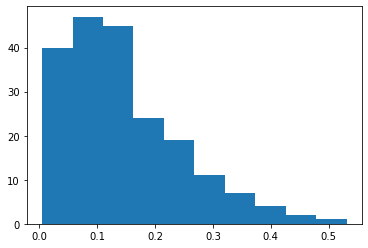

In [376]:
plt.hist(out_l.sum(axis=1))

In [434]:
out_fr_rank = out_l.sum(axis=1).argsort()
out_l[out_fr_rank]

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 7.30127893e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.55129281e-05, 2.86537884e-05, 3.57877796e-05],
       ...,
       [1.05070692e-02, 1.04182163e-02, 1.05071284e-02, ...,
        1.05125603e-02, 9.94187958e-03, 1.05796082e-02],
       [1.07400900e-02, 1.07564242e-02, 1.08820630e-02, ...,
        1.06828835e-02, 1.01744167e-02, 1.08722663e-02],
       [1.14059336e-02, 1.14849417e-02, 1.16071276e-02, ...,
        1.13616089e-02, 1.07740765e-02, 1.16263986e-02]])

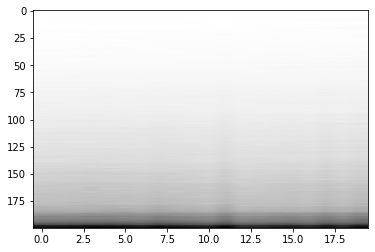

In [435]:
plt.imshow(out_l[out_fr_rank],aspect='auto')

/tmp/ipykernel_544861/3537806969.py:1: RuntimeWarning: invalid value encountered in true_divide
  out_l_norm = out_l/out_l.max(axis=1,keepdims=True)


(0.0, 1.0)

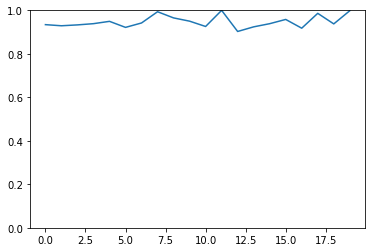

In [476]:
out_l_norm = out_l/out_l.max(axis=1,keepdims=True)
plt.plot(out_l_norm[out_fr_rank][190])
plt.ylim([0,1])
